![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Machine Learning Methods </center>
## <center> Lecture 17 - Boosting</center>
### <center> AdaBoost</center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/MachineLearningMethod/14_Boosting/MainAdaBoost1.ipynb)

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import numpy             as np
import pandas            as pd
import seaborn           as sns
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc('font', **{'size' : 16})

# np.random.seed(1)

### Generate some data:

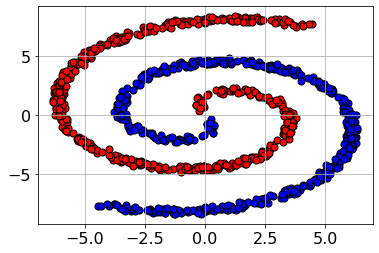

In [3]:
N     = 500
vN    = np.sqrt(np.random.rand(N, 1)) * 480 * 2 * np.pi / 360
vCos  = -vN * np.cos(vN) + np.random.rand(N, 1) / 2
vSin  = vN  * np.sin(vN) + np.random.rand(N, 1) / 2
mX1   =  np.c_[vCos, vSin]
mX2   = -np.c_[vCos, vSin]
mX    = np.r_[mX1, mX2]
vY    = np.r_[-np.ones(N), np.ones(N)]
N     = len(vY)
vIdx0 = vY == -1
vIdx1 = vY ==  1

plt.figure(), plt.grid(True)
plt.scatter(mX[vIdx0,0], mX[vIdx0,1], s=50, color='r', edgecolors='k')
plt.scatter(mX[vIdx1,0], mX[vIdx1,1], s=50, color='b', edgecolors='k')
plt.show()

### Train an AdaBoost classifier:

In [4]:
from sklearn.ensemble import AdaBoostClassifier

M         = 100
oAdaBoost = AdaBoostClassifier(n_estimators=M, algorithm='SAMME').fit(mX, vY)

### Plot:

In [5]:
def PlotAdaBoost(M):
    
    def Predict(oAdaBoost, M, mX, vY = None):
        N         = mX.shape[0]
        vW        = np.ones(N) / N
        vH        = np.zeros(N)
        vTrainErr = np.full(M, np.nan)
        vLoss     = np.full(M, np.nan)
        for mm in range(M):
            alpha_m = oAdaBoost.estimator_weights_[mm]
            h_m     = oAdaBoost.estimators_[mm]
            vHatYm  = h_m.predict(mX)
            vH     += alpha_m * vHatYm

            if vY is not None:
                vW             = vW * np.exp(-alpha_m * vY * h_m.predict(mX))
                vW            /= np.sum(vW)
                vTrainErr[mm]  = np.mean(np.sign(vH) != vY)
                vLoss[mm]      = np.mean(np.exp(-vH * vY))
        
        vH = np.sign(vH)
        
        return vH, vW, vTrainErr, vLoss
        
    v0       = np.linspace(mX[:,0].min(), mX[:,0].max(), 150)
    v1       = np.linspace(mX[:,1].min(), mX[:,1].max(), 150)
    XX0, XX1 = np.meshgrid(v0, v1)
    XX       = np.c_[XX0.ravel(), XX1.ravel()]

    _, vW, vTrainErr, vLoss = Predict(oAdaBoost, M, mX, vY)
    ZZ                      = Predict(oAdaBoost, M, XX)[0]
    ZZ                      = np.reshape(ZZ, XX0.shape)

    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    plt.contourf(XX0, XX1, ZZ, colors=['red', 'blue'], alpha=0.3)
    plt.scatter(mX[vIdx0,0], mX[vIdx0,1], s=50*N*vW[vIdx0], color='r', edgecolors='k')
    plt.scatter(mX[vIdx1,0], mX[vIdx1,1], s=50*N*vW[vIdx1], color='b', edgecolors='k')
    plt.title('$M = ' + str(M) + '$')
                                        
    plt.subplot(1,2,2), plt.grid(True)
    plt.plot(vTrainErr, 'b', lw=2, label='train error')
    plt.plot(vLoss,     'r', lw=2, label='train loss')
    plt.legend()
    
    plt.tight_layout()

In [6]:
from ipywidgets import interact, IntSlider, Layout

mSlider = IntSlider(min=1, max=M, step=1, value=1, layout=Layout(width='80%'))
interact(PlotAdaBoost, M=mSlider)
plt.show()

interactive(children=(IntSlider(value=1, description='M', layout=Layout(width='80%'), min=1), Output()), _dom_…

### Load heart dataset:
https://www.kaggle.com/ronitf/heart-disease-uci

In [7]:
dData = pd.read_csv('../../data/Heart/heart.csv')
dData

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [8]:
mX = dData.drop(columns=['target']).values
vY = dData['target'].values

### Train an AdaBoost classifier (cross-validation)

In [11]:
from sklearn.model_selection import cross_val_predict, KFold

vHatY = cross_val_predict(AdaBoostClassifier(n_estimators=15), mX, vY, cv=KFold(len(vY), shuffle=True))
np.mean(vY == vHatY)

0.8316831683168316